In [1]:
from fastai.text.all import *

In [2]:
lang = 'de'
backwards = False
bs=128
vocab_sz = 15000
num_workers=18
step = 'ft' # fine-tuning

In [3]:
direction = 'fwd' if backwards == False else 'bwd'

In [4]:
wiki = f'{lang}wiki'
base_path = Path('data')
path = base_path/wiki
model_base_path = path/'model'
model_path = model_base_path/step/direction
spm_path = model_base_path/step/'spm'
lm_fns = [(model_base_path/'lm'/direction/f'{lang}_wikitext').absolute(), 
          (model_base_path/'lm'/direction/f'{lang}_wikitext_vocab').absolute()]

In [5]:
data_path = path/'germeval'

In [6]:
lm_fns, spm_path, direction, backwards

([Path('/data/projects/git/fastai_ulmfit_german/data/dewiki/model/lm/bwd/de_wikitext'),
  Path('/data/projects/git/fastai_ulmfit_german/data/dewiki/model/lm/bwd/de_wikitext_vocab')],
 Path('data/dewiki/model/ft/spm'),
 'bwd',
 True)

## Prepare corpus for fine tuning

In [7]:
df = pd.read_csv(data_path/'data_lm.csv')

In [8]:
df

,text
0,"Meine Mutter hat mir erzählt, dass mein Vater einen Wahlkreiskandidaten nicht gewählt hat, weil der gegen die Homo-Ehe ist ☺"
1,"Meine Reaktion; |LBR| Nicht jeder Moslem ist ein Terrorist. Aber jeder Moslem glaubt an Überlieferungen, die Gewalt und Terror begünstigen."
2,"#Merkel rollt dem Emir von #Katar, der islamistischen Terror unterstützt, den roten Teppich aus.Wir brauchen einen sofortigen #Waffenstopp!"
3,„Merle ist kein junges unschuldiges Mädchen“ Kch....... 😱 #tatort
4,Asylantenflut bringt eben nur negatives für Deutschland. Drum Asylanenstop und Rückführung der Mehrzahl.
...,...
512382,"🇪🇺 Keine Lust auf #Europa? Zurück zu nationalen Grenzen? Drei junge #Europäer wollten dabei nicht länger zusehen. Und gründeten #Volt. Eine Partei, die Europa einen soll. ⏩ #Europawahl2019"
512383,"Morgen um 11 Uhr geht die große Sprayer-Aktion an der Bahnunterführung in #Langen los. Wir sind total gespannt auf die Kunstwerke, die dort entstehen und verabschieden uns schon mal von den alten Schmierereien. Mehr Infos: #Graffiti #StreetArt"
512384,Neuigkeit: Gesundheitsgefahr: Krebshilfe fordert Werbeverbot für E-Zigaretten #news
512385,Hundeanhänger 925 Silber und recyceltes Holz sabina #Tchotchke #kreativerTchotchke #handgefertigt Cane ciondolo in argento 925 e sabina legno riciclato #gioielli #gioiellicreativi #fattoamano


## Fine tune model

In [9]:
if spm_path.exists():
    tok = SentencePieceTokenizer(lang=lang, max_vocab_sz=vocab_sz, sp_model=spm_path/'spm.model')
    print(f'SentencePiece Model exists - using {spm_path}')
else:
    tok = SentencePieceTokenizer(lang=lang, max_vocab_sz=vocab_sz, cache_dir=spm_path)

SentencePiece Model exists - using data/dewiki/model/ft/spm


In [10]:
dblocks = DataBlock(blocks=(TextBlock.from_df('text', tok=tok, is_lm=True, backwards=backwards)),
                    get_x=ColReader('text'), 
                    splitter=RandomSplitter(valid_pct=0.1, seed=42))
dls = dblocks.dataloaders(df, bs=bs, num_workers=num_workers)

/home/florian/miniconda3/envs/fastai/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [11]:
dls.show_batch()

,text,text_
0,"️ ⚪ ▁ ▁hahohe ▁# berlin gehört zukunft ▁die ▁# : ▁ ▁der ▁von ▁präsentiert , rückblick - end ▁wochen ▁unser ▁xxmaj - ▁ t ute lä ▁einge ▁ist phase ▁ ▁xxmaj ▁heiße ▁die ▁xxmaj 🔵 ▁ ▁xxbos 🙃 ▁... sprüche ▁ ▁xxmaj "" race g ▁dis ▁a ▁/ ▁everything ing ▁ruin s ' ▁it , rek t ▁ ▁xxmaj ▁star ▁xxmaj t ' n ▁is this ▁"" ▁gleichen ▁die ▁ich ▁höre","⚪ ▁ ▁hahohe ▁# berlin gehört zukunft ▁die ▁# : ▁ ▁der ▁von ▁präsentiert , rückblick - end ▁wochen ▁unser ▁xxmaj - ▁ t ute lä ▁einge ▁ist phase ▁ ▁xxmaj ▁heiße ▁die ▁xxmaj 🔵 ▁ ▁xxbos 🙃 ▁... sprüche ▁ ▁xxmaj "" race g ▁dis ▁a ▁/ ▁everything ing ▁ruin s ' ▁it , rek t ▁ ▁xxmaj ▁star ▁xxmaj t ' n ▁is this ▁"" ▁gleichen ▁die ▁ich ▁höre ng"
1,"▁mittel ▁xxmaj ▁der , ▁gefahr ▁xxmaj ▁möglicherweise ▁läuft , ▁ist gen wo ▁ausge ▁zu wer ▁( ▁🤔 . ▁sein gen wo ▁ausge ▁und t il fe ▁ausge ▁letzte ▁xxmaj ▁ins ▁bis ▁alles ▁nicht ▁ja ▁muss ▁es ▁xxmaj 💐 ▁ . ▁lesen ▁zu ▁dich ▁xxmaj , ▁schön ▁xxmaj ! ▁nicht ▁gar ▁xxmaj ? ▁müll ▁xxmaj ▁aber ▁xxmaj - ▁ ! ▁ja ▁definitiv - ▁ ▁gedanken ▁xxmaj ▁xxbos ▁germany ▁xxmaj - ▁ ingen z","▁xxmaj ▁der , ▁gefahr ▁xxmaj ▁möglicherweise ▁läuft , ▁ist gen wo ▁ausge ▁zu wer ▁( ▁🤔 . ▁sein gen wo ▁ausge ▁und t il fe ▁ausge ▁letzte ▁xxmaj ▁ins ▁bis ▁alles ▁nicht ▁ja ▁muss ▁es ▁xxmaj 💐 ▁ . ▁lesen ▁zu ▁dich ▁xxmaj , ▁schön ▁xxmaj ! ▁nicht ▁gar ▁xxmaj ? ▁müll ▁xxmaj ▁aber ▁xxmaj - ▁ ! ▁ja ▁definitiv - ▁ ▁gedanken ▁xxmaj ▁xxbos ▁germany ▁xxmaj - ▁ ingen z ▁kit"
2,"ve ’ ▁i ▁xxmaj ▁and , er ▁care ing ▁model ▁a ing su ▁pur , 37 ▁ ▁is d ▁da ▁my ▁xxbos 🐰 ▁ ! ▁herzen ▁xxmaj ▁im ▁sonne ▁xxmaj ▁und tage ▁fest ▁xxmaj ▁frohe ▁xxmaj 💫 ▁ ! ▁machen ▁aufmerksam ▁podcast ▁xxmaj ▁meinen ▁auf ▁mal ▁alle ▁bitte ▁xxmaj ? ▁team ▁xxmaj ▁im ▁ladies ▁xxmaj ▁euch ▁bei ▁ihr ▁habt ▁xxmaj ! ▁seid ▁dabei ▁ihr ▁dass , ▁mich ▁freue ▁ich ▁xxmaj * ende","’ ▁i ▁xxmaj ▁and , er ▁care ing ▁model ▁a ing su ▁pur , 37 ▁ ▁is d ▁da ▁my ▁xxbos 🐰 ▁ ! ▁herzen ▁xxmaj ▁im ▁sonne ▁xxmaj ▁und tage ▁fest ▁xxmaj ▁frohe ▁xxmaj 💫 ▁ ! ▁machen ▁aufmerksam ▁podcast ▁xxmaj ▁meinen ▁auf ▁mal ▁alle ▁bitte ▁xxmaj ? ▁team ▁xxmaj ▁im ▁ladies ▁xxmaj ▁euch ▁bei ▁ihr ▁habt ▁xxmaj ! ▁seid ▁dabei ▁ihr ▁dass , ▁mich ▁freue ▁ich ▁xxmaj * ende spoiler"
3,▁geheim ▁seine ▁deshalb ▁hat ▁kollege ▁xxmaj . ▁beleidigt ▁einmal ▁nur ▁jeden ▁habe ▁und ▁call ▁xxmaj ▁con ▁xxmaj ▁im ▁brav ▁war ▁ich ▁xxmaj ▁xxbos sz ▁ ▁# ▁ard ▁xxup ▁# pa d ▁ ▁# dr n ▁ ▁# ▁linke ▁# ▁faz ▁# ▁csu ▁# ▁spd ▁# ▁cdu ▁xxup ▁# ! gemacht ▁vor ▁haben ▁bayern ▁xxmaj ▁# ▁und ▁hessen ▁xxmaj ▁# ! wünscht ▁ ▁koalition ▁xxmaj ▁große ▁xxmaj ▁keine ▁land ▁xxmaj ▁dieses ▁dass ▁lernen,▁seine ▁deshalb ▁hat ▁kollege ▁xxmaj . ▁beleidigt ▁einmal ▁nur ▁jeden ▁habe ▁und ▁call ▁xxmaj ▁con ▁xxmaj ▁im ▁brav ▁war ▁ich ▁xxmaj ▁xxbos sz ▁ ▁# ▁ard ▁xxup ▁# pa d ▁ ▁# dr n ▁ ▁# ▁linke ▁# ▁faz ▁# ▁csu ▁# ▁spd ▁# ▁cdu ▁xxup ▁# ! gemacht ▁vor ▁haben ▁bayern ▁xxmaj ▁# ▁und ▁hessen ▁xxmaj ▁# ! wünscht ▁ ▁koalition ▁xxmaj ▁große ▁xxmaj ▁keine ▁land ▁xxmaj ▁dieses ▁dass ▁lernen ▁sollte
4,▁ ▁xxup ▁xxbos s ▁gut ▁xxmaj ▁xxbos ! ▁bericht ▁xxmaj ▁zum s ' ▁geht ▁hier ▁xxmaj . gang ▁werde ▁xxmaj ▁seinen ▁über ▁berichtet ) ▁gruppe ▁xxmaj ▁o & b ▁( hm bö ▁ ▁xxmaj ▁ernst ▁xxmaj . ▁dr ▁xxmaj : er nehm ▁unter ▁xxmaj en ▁beeindruckend ▁einem ▁mit ▁veranstaltung ▁xxmaj e ▁genial ▁xxmaj - ▁ : ▁münchen ▁xxmaj werk s förderung ▁berufs ▁xxmaj ▁von ▁neues ▁xxmaj ▁xxbos ▁teuer ▁# ment invest ▁,▁xxup ▁xxbos s ▁gut ▁xxmaj ▁xxbos ! ▁bericht ▁xxmaj ▁zum s ' ▁geht ▁hier ▁xxmaj . gang ▁werde ▁xxmaj ▁seinen ▁über ▁berichtet ) ▁gruppe ▁xxmaj ▁o & b ▁( hm bö ▁ ▁xxmaj ▁ernst ▁xxmaj . ▁dr ▁xxmaj : er nehm ▁unter ▁xxmaj en ▁beeindruckend ▁einem ▁mit ▁veranstaltung ▁xxmaj e ▁genial ▁xxmaj - ▁ : ▁münchen ▁xxmaj werk s förderung ▁berufs ▁xxmaj ▁von ▁neues ▁xxmaj ▁xxbos ▁teuer ▁# ment invest ▁ ▁#
5,"ing und so - ic ▁german ▁with ▁them place ▁re ▁and ▁language english ▁ ▁the ▁from ots ro ▁ ic man ger - ▁non ▁with s word ▁ ▁all ve mo ▁re ▁to ▁attempt ▁an ▁is ▁which , ish gl ▁an ▁about ed ▁learn ▁i ▁today ▁xxbos . ▁donnerstag ▁xxmaj ▁bis ▁xxmaj . ▁nähe ▁xxmaj ▁

In [12]:
learn = language_model_learner(dls, AWD_LSTM, drop_mult=0.5, pretrained=True, pretrained_fnames=lm_fns, 
                               metrics=[accuracy, Perplexity()]).to_fp16()
learn.path = model_path

SuggestedLRs(lr_min=0.03019951581954956, lr_steep=0.03981071710586548)

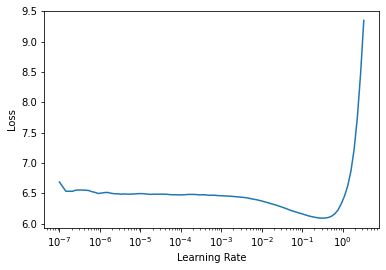

In [13]:
learn.lr_find()

In [14]:
lr = 3e-2

In [15]:
learn.fit_one_cycle(1, lr, moms=(0.8,0.7,0.8))

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,4.279651,4.108228,0.338827,60.838799,02:11


In [16]:
learn.unfreeze()
learn.fit_one_cycle(10, slice(lr/100,lr), moms=(0.8,0.7,0.8))

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,4.064413,3.944313,0.357794,51.640865,02:39
1,4.004095,3.892355,0.365815,49.026230,02:39
2,3.931869,3.803417,0.377284,44.854179,02:39
3,3.838235,3.734735,0.385741,41.876938,02:38
4,3.765229,3.671536,0.393115,39.312233,02:39
5,3.680556,3.611330,0.400901,37.015244,02:40
6,3.626554,3.551534,0.408415,34.866768,02:40
7,3.553681,3.502916,0.414827,33.212170,02:42
8,3.488462,3.474455,0.418645,32.280220,02:42
9,3.439993,3.469495,0.419560,32.120518,02:40


## Saving fine tuned model, encoder and vocab

In [17]:
lm_ft_fns = [(model_path/f'{lang}_ft').absolute(), 
             (model_path/f'{lang}_ft_vocab.pkl').absolute()]

In [18]:
learn.to_fp32()

In [19]:
learn.save(lm_ft_fns[0], with_opt=False)

Path('/data/projects/git/fastai_ulmfit_german/data/dewiki/model/ft/bwd/de_ft.pth')

In [20]:
learn.save_encoder(f'{lm_ft_fns[0]}_encoder')

In [21]:
with open(lm_ft_fns[1], 'wb') as f:
      pickle.dump(learn.dls.vocab, f)